<a href="https://colab.research.google.com/github/jecampagne/JaxTutos/blob/main/JIT_fractals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NB. better to activate a GPU (ie. change the Execution type in Colab)

In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import numpy as np

import jax
import jax.numpy as jnp

from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian

jax.config.update("jax_enable_x64", True)
from functools import partial

import matplotlib as mpl
from matplotlib import pyplot as plt


In [5]:
jax.__version__ # ok <= 0.4.26

'0.4.26'

# Theme: use Just-In-Time compilation using control flow

Let us explore the Julia set. Define $(c_x,c_z)$ then inititialiaze
$$
x_0 = x_{pix}; y_0 = y_{pix}
$$
then iterate
$$
\begin{cases}
x_{n+1} &= x_n^2 - y_n^2 + c_x \\
y_{n+1} &= 2x_n y_n + c_y
\end{cases}
$$

As soon as $(x_n,y_n)$ leaves the disk of center $(0,0)$ and radius $r=2$ we stop the recursion;  as well as if it $n$ reaches an arbitrary maximum value ("MAX_ITERATION") meaning that the pixel $(x_0,y_0)$ belongs to the Julia fractal. Depending on the couple $(c_x,c_y)$, we obtain different fractals.

## Let try a simple numpy code using for-loops

In [6]:
XMIN, XMAX, YMIN, YMAX = -1.25, 1.25, -1.25, 1.25   # physical sapce
LARGEUR, HAUTEUR = 1024, 1024                         # image size
MAX_ITERATION = 150

In [7]:
cx, cy = 0.285, 0.01

In [8]:
# Set the numpy array of the final image
Pixels = np.zeros(shape=(LARGEUR, HAUTEUR))


In [9]:
for iy in range(HAUTEUR):
    for ix in range(LARGEUR):
        xn = (ix * (XMAX - XMIN) / LARGEUR + XMIN)
        yn = (iy * (YMIN - YMAX) / HAUTEUR + YMAX)
        n = 0
        while (xn * xn + yn * yn) < 4 and n < MAX_ITERATION:  # condition to stop the iteration
            tmp_x = xn
            tmp_y = yn
            xn = tmp_x * tmp_x - tmp_y * tmp_y + cx
            yn = 2 * tmp_x * tmp_y + cy
            n = n + 1
        if n == MAX_ITERATION: # the pixel is not a member of the Julia Set
            Pixels[ix,iy]=0
        else:                   # the pixel is a member of the Julia Set
            R = (3.*n)/256
            G = (1.*n)/256
            B = (10.*n)/256
            Pixels[ix,iy]=0.222*R + 0.666*G + 0.111*B

In [10]:
def MatplotlibClearMemory():
    #usedbackend = matplotlib.get_backend()
    #matplotlib.use('Cairo')
    allfignums = mpl.pyplot.get_fignums()
    for i in allfignums:
        fig = mpl.pyplot.figure(i)
        fig.clear()
        mpl.pyplot.close( fig )
    #matplotlib.use(usedbackend)


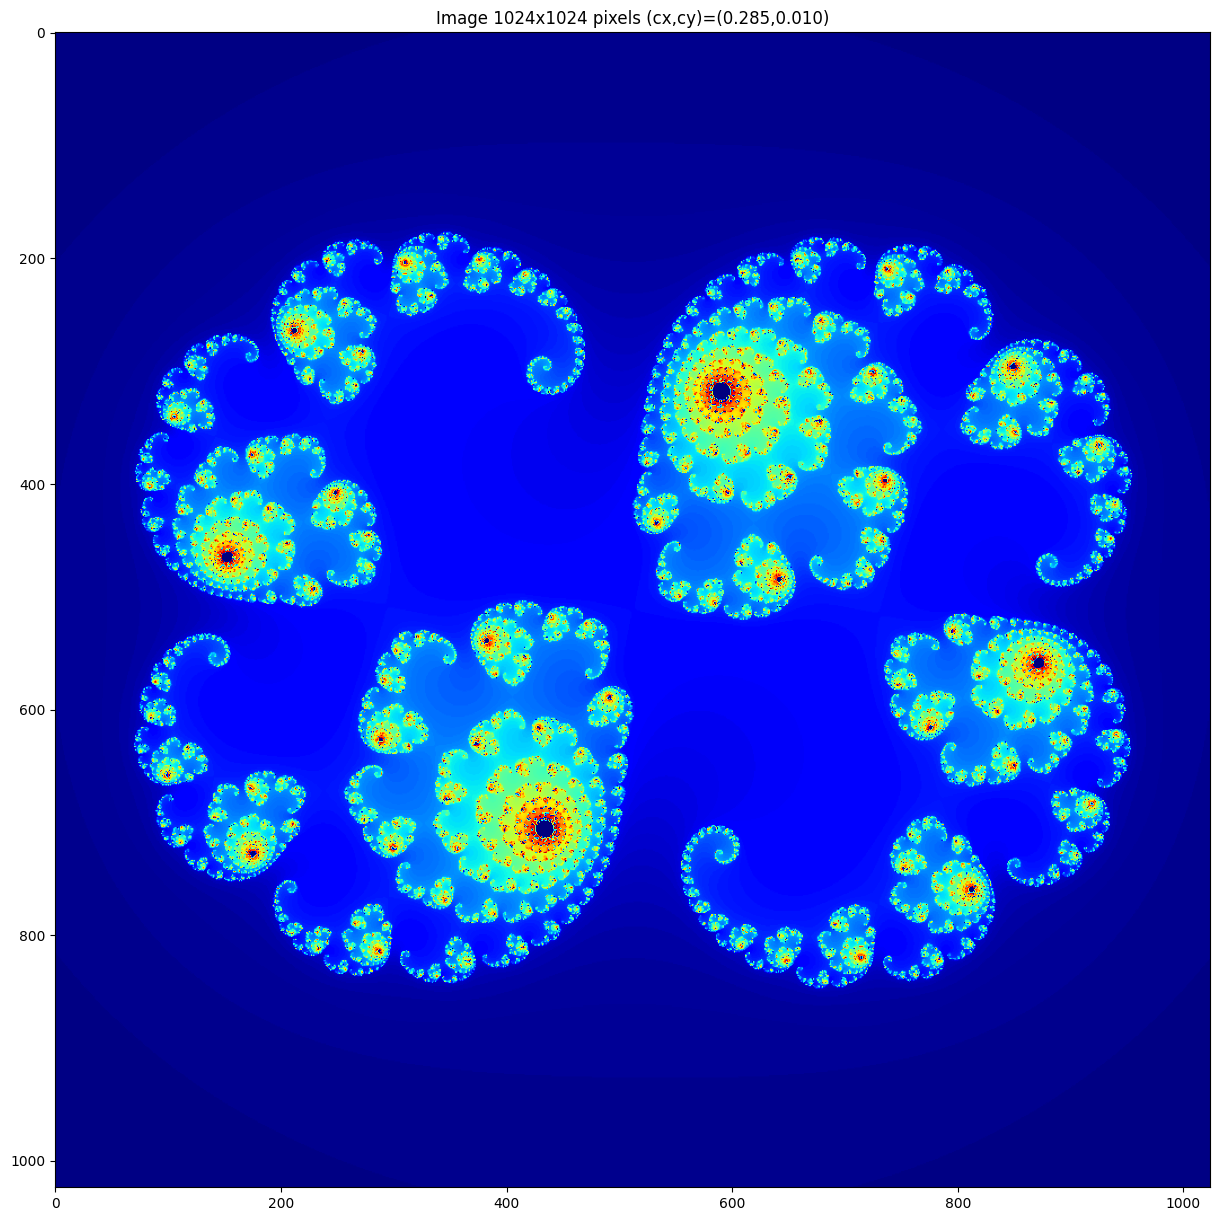

In [11]:
plt.figure(figsize=(15,15))
plt.imshow(Pixels,cmap=mpl.cm.jet);
plt.title(fr"Image {HAUTEUR}x{LARGEUR} pixels (cx,cy)=({cx:.3f},{cy:.3f})");
plt.show()
MatplotlibClearMemory()

## JAX implementation Julia set

Main message : forget about for loop. This will activate JIT also.


Looking at the code we ashk ourselves:
- how to deal with while loop?
- what about the condition on n?

### Condition
Here a function $f(x,y)$ such that
$$
f(x,y) = \begin{cases}
y & if\ x>1 \\
y^2 & if x\leq 1
\end{cases}
$$


In [12]:
def f(x,y):
    return jax.lax.cond(x>1,lambda p: p, lambda p: p**2,operand=y)


In [13]:
# nested vmap
vf = jax.vmap(jax.vmap(f, in_axes=(None, 0)), in_axes=(0, None))

In [14]:
# x= [0.5,2] and y=(0,2,3)
vf(jnp.array([0.5,2]),jnp.array([0.,2.,3.]))
# first row x=0.5 => return y*2
# second row x=2 =>  return y

Array([[0., 4., 9.],
       [0., 2., 3.]], dtype=float64)

You can have more expresive predicate. Formally the `jax.lax.cond` is equivalent to
```python
def cond(pred, true_fun, false_fun, *operands):
  if pred:
    return true_fun(*operands)
  else:
    return false_fun(*operands)
```

### While

`jax.lax.while_loop(cond_fun, body_fun, init_val)` is equivalent to

```python
def while_loop(cond_fun, body_fun, init_val):
  val = init_val
  while cond_fun(val):
    val = body_fun(val)
  return val
```

In [15]:
def julia(args_vars):

    cx,cy, XMIN, XMAX, YMIN, YMAX, LARGEUR, HAUTEUR, MAX_ITERATION = args_vars

    def func(ix,iy):

        def body(val):
            n,x,y = val
            xn = x * x - y * y + cx
            yn = 2 * x * y     + cy
            n = n+1
            return (n,xn,yn)

        cond_fun = lambda p : ((p[1]**2 + p[2]**2 < 4.) & (p[0] < MAX_ITERATION))

        x0 = (ix * (XMAX - XMIN) / LARGEUR + XMIN)
        y0 = (iy * (YMIN - YMAX) / HAUTEUR + YMAX)

        u = (0,x0,y0)
        u = jax.lax.while_loop(cond_fun,body,u)
        n = u[0]

        pixel_val = jax.lax.cond(jnp.isclose(n,MAX_ITERATION),
                                 lambda _: 0.,
                                 lambda p: 0.222*((3*p)/256) + 0.666*(p/256) + 0.111*((10*p)/256),
                                operand=n)


        return pixel_val

    #See Multi_GPUs nb
    #X,Y = jnp.meshgrid(jnp.arange(0, LARGEUR),jnp.arange(0, HAUTEUR))
    #mapped = jax.vmap(func, in_axes=(0, 0))
    #result = mapped(X,Y)

    mapped = jit(vmap(vmap(func, in_axes=(None, 0)), in_axes=(0, None)))
    result = mapped(jnp.arange(0, LARGEUR), jnp.arange(0, HAUTEUR))

    return result

In [20]:
HAUTEUR=LARGEUR=1024
args = (cx,cy, XMIN, XMAX, YMIN, YMAX, HAUTEUR, HAUTEUR, 150)
img = julia(args)

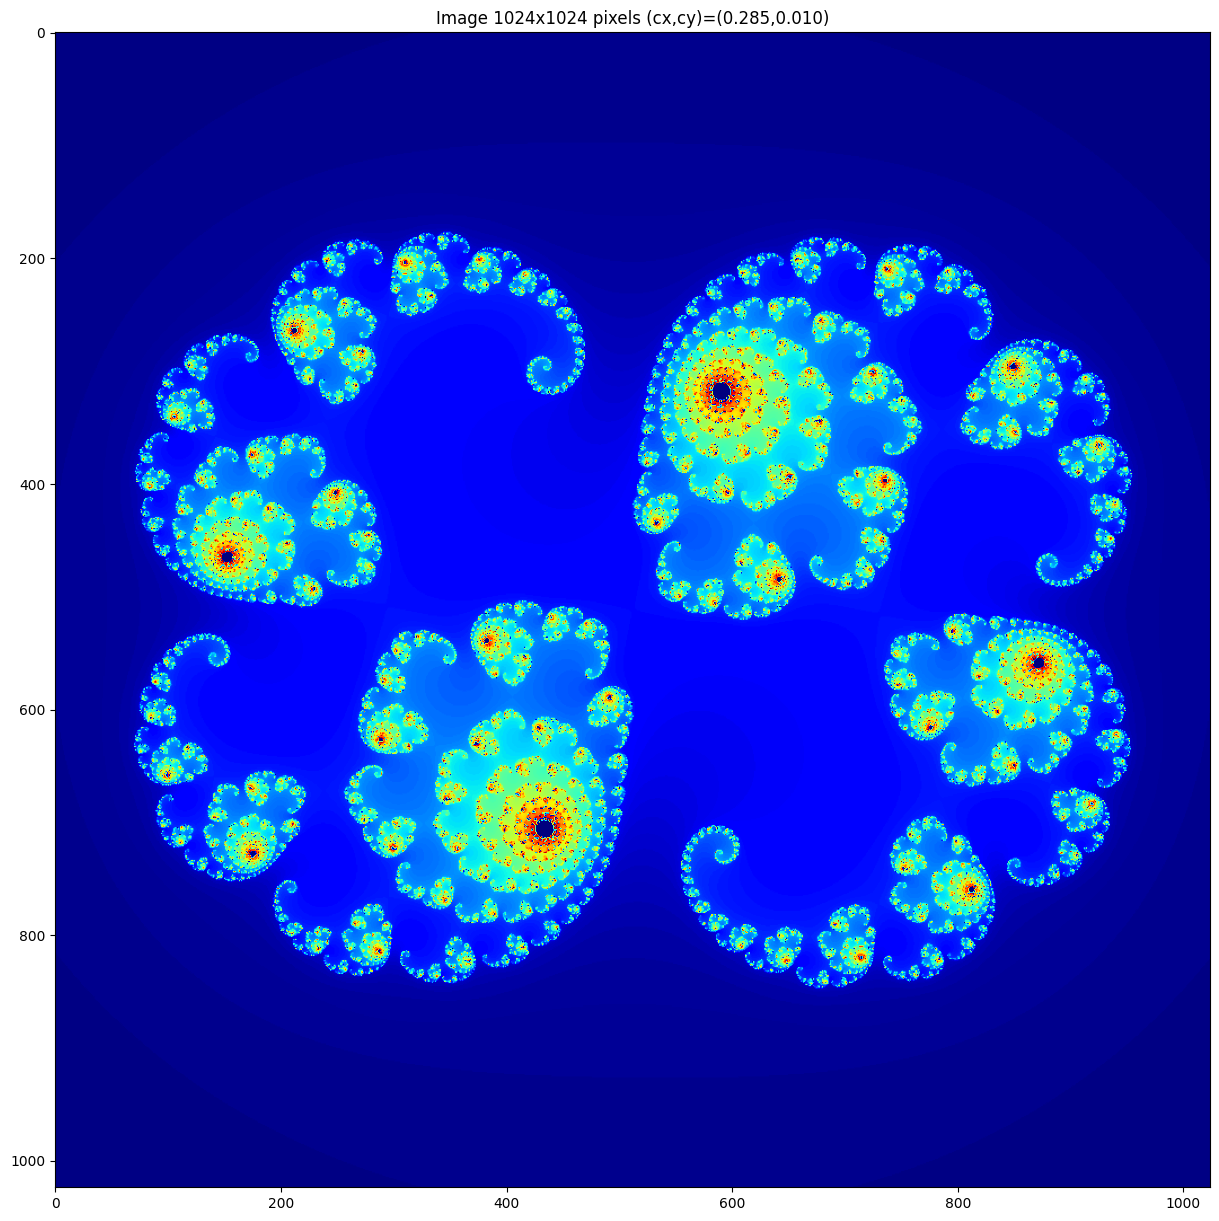

In [21]:
plt.figure(figsize=(15,15))
plt.imshow(img,cmap=mpl.cm.jet);
plt.title(fr"Image {HAUTEUR}x{LARGEUR} pixels (cx,cy)=({cx:.3f},{cy:.3f})");
plt.show()
MatplotlibClearMemory()

Not sure that you have seen the difference in time wrt the python code but 1) this is a 2048x2048 pixels image 2) look at the time indicated for the cells [12] & [22]

Lets try an other (cx,cy) and a 4096x4096 images

In [22]:
# Better to run on GPU
HAUTEUR=LARGEUR=4096
cx, cy = 0.3,0.015
args = (cx,cy, XMIN, XMAX, YMIN, YMAX, 4096, 4096, 150)
img = julia(args)


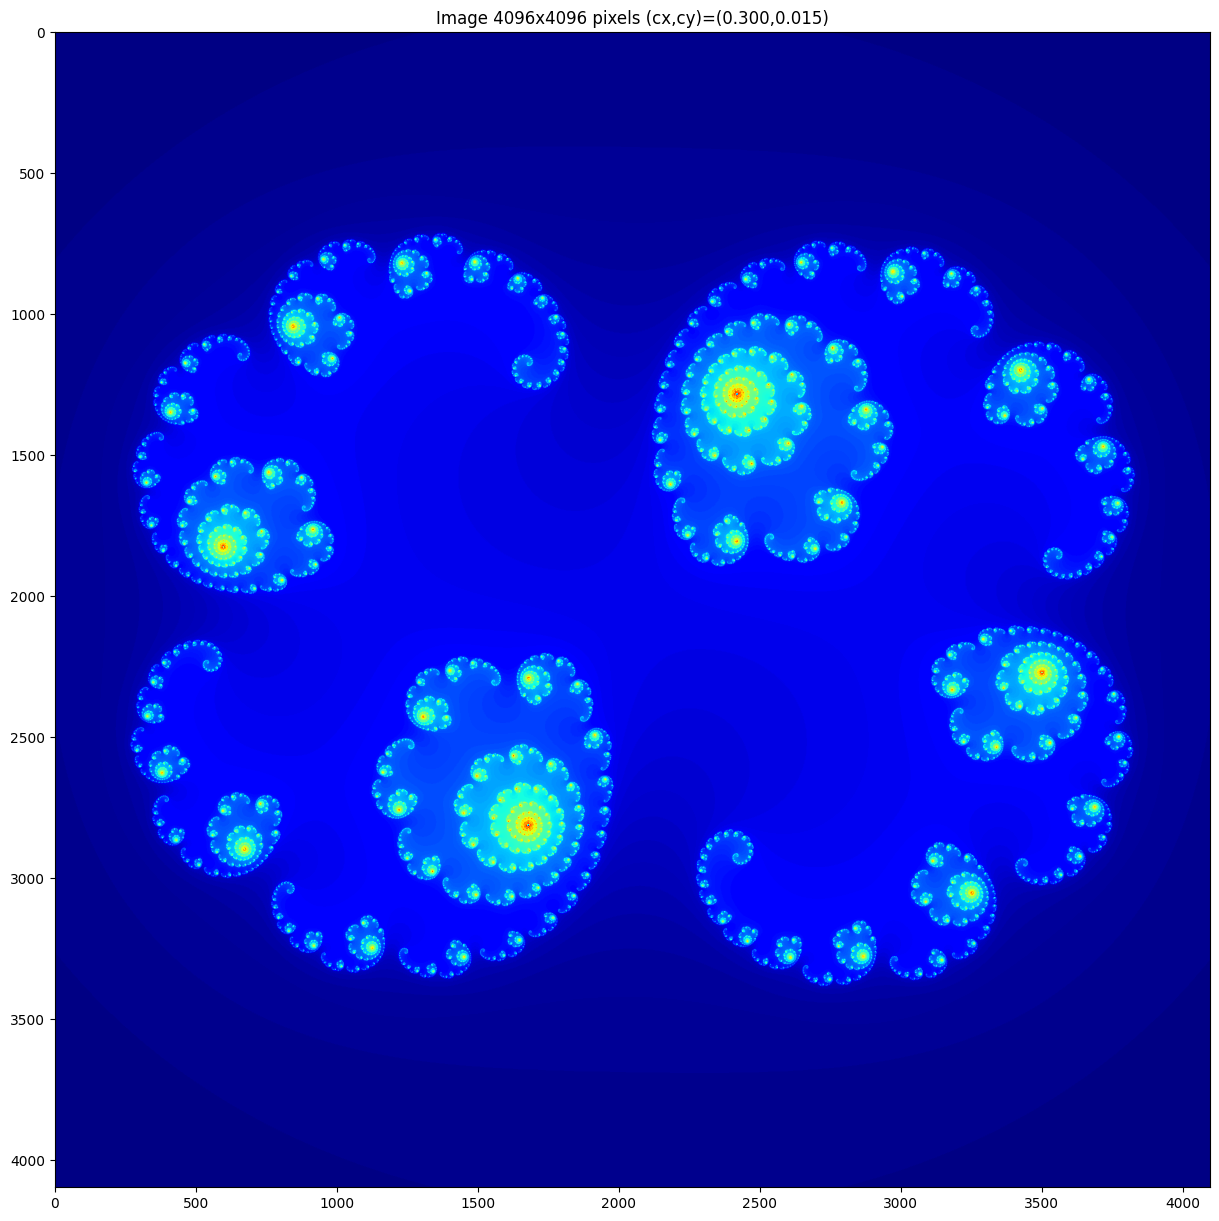

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(img,cmap=mpl.cm.jet);
plt.title(fr"Image {HAUTEUR}x{LARGEUR} pixels (cx,cy)=({cx:.3f},{cy:.3f})");
plt.show()
MatplotlibClearMemory()

As you turn you can explore other (cx,cy) values..


## Mandelbrot
If you want the iconic Mandelbrot set, we have almost nothig to change

$$
XMIN,XMAX,YMIN,YMAX = (-2.0, +0.5, -1.25,+1.25)
$$

now the seed is always $(x_0,y_0)={0,0}$, the recurence is the same, although now it is  $(c_x,c_y)$ that is tested.

In [ ]:
def mandelbrot(args_vars):

    XMIN, XMAX, YMIN, YMAX, LARGEUR, HAUTEUR, MAX_ITERATION = args_vars

    def func(ix,iy):

        cx = (ix * (XMAX - XMIN) / LARGEUR + XMIN)
        cy = (iy * (YMIN - YMAX) / HAUTEUR + YMAX)

        def body(val):
            n = val[0]
            x = val[1]
            y = val[2]
            xn = x * x - y * y + cx
            yn = 2 * x * y     + cy
            n = n+1
            return (n,xn,yn)

        cond_fun = lambda p : ((p[1]**2 + p[2]**2 < 4.) & (p[0] < MAX_ITERATION))

        u = (0,0,0)
        u = jax.lax.while_loop(cond_fun,body,u)
        n = u[0]

        pixel_val = jax.lax.cond(jnp.isclose(n,MAX_ITERATION),
                                 lambda _: 0.,
                                 lambda p: 0.222*((3*p)/256) + 0.666*(p/256) + 0.111*((10*p)/256),
                                operand=n)


        return pixel_val

    mapped = jit(vmap(vmap(func, in_axes=(None, 0)), in_axes=(0, None)))
    result = mapped(jnp.arange(0, LARGEUR), jnp.arange(0, HAUTEUR))

    return result

In [ ]:
XMIN, XMAX, YMIN, YMAX = -2, +0.5, -1.25, +1.25
HAUTEUR=LARGEUR=4096
args = (XMIN, XMAX, YMIN, YMAX, LARGEUR, HAUTEUR, 150)
img = mandelbrot(args)

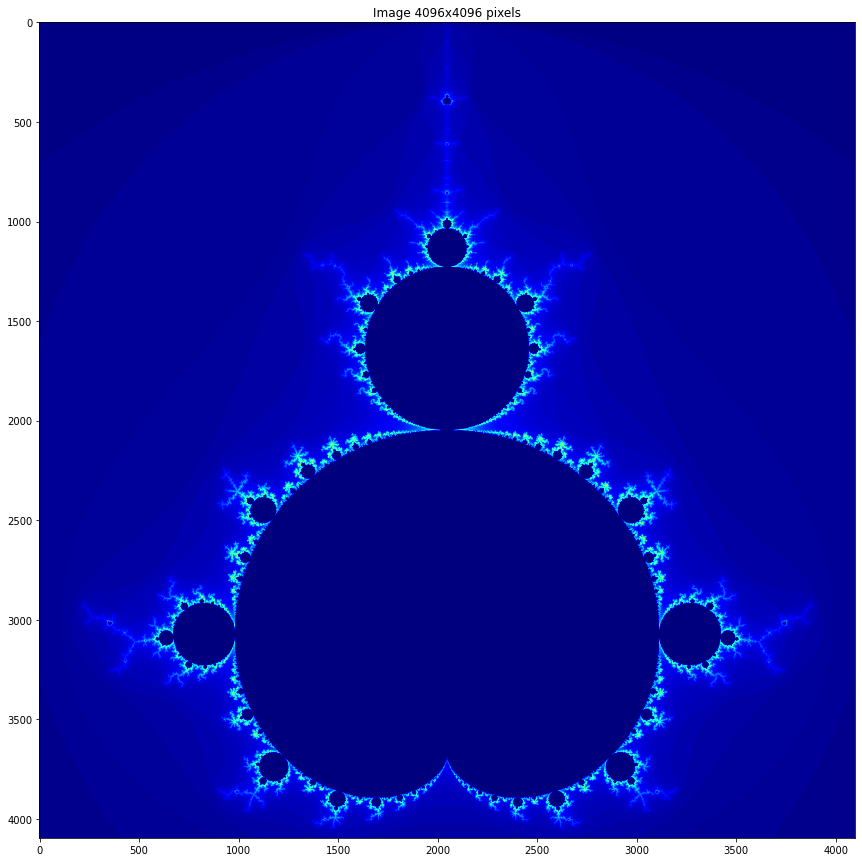

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(img,cmap=mpl.cm.jet);
plt.title(fr"Image {HAUTEUR}x{LARGEUR} pixels");
plt.show()
MatplotlibClearMemory()

# Takeaway
- forget about for loop
- JIT is automatically performed
- Your code is automatically adapted to the device CPU vs GPU w/o any user adaptation. However local TensorFlow environment variables can help to fit in GPU.


